# Double Exponential Jump Diffusion (DEJD) Validation Report - New Variation (DEX 600 & 1500)

#### Report Date : 28 Aug 2023

### <u>Squad Members</u>
| Area | Person In Charge | 
| :- | :- | 
| Squad Leader | Harsh (harsh@deriv.com) | 
| Project Manager | Maria Semashko (maria.semashko@deriv.com) | 
| Product Owner | Antoine Mille (antoine.mille@deriv.com)  | 
| Backend | Afshin Paydar (afshin.paydar@deriv.com) | 
| Model Validation | Kuan Lim (kuanlim@deriv.com)|



## Product Information

Product Specification : https://docs.google.com/document/d/1PO6DN2w2AkK-d8faAwmFWDkJu02LLgsF/edit

Perl Code (8 Aug 2023): https://github.com/regentmarkets/perl-Feed-Index-JumpDiffusion/tree/b37fe3cf4b62104c5af82fb020bcd3f6d05f32c2

### <u>Background & Introduction</u>

There were 2 variations of Double Exponential Jump Diffusion (DEJD) indices launched on May 2023, which are DEX D900 and DEX U900.

In this time, another 4 variations are suggested to be part of the DEJD family, for the purpose of diversifying the concentration risk on a particular index, especially either on DOWN or UP.

The product description and the construction are exactly the same, except the parameters for these 4 variations are set differently. 

For information about the index construction, please refer to the Double Exponential Jump Diffusion (DEJD) Index Validation Report as of 22 May 2023 ( [link here](https://github.com/regentmarkets/quants-model-validation/blob/master/Validation/Feeds/Double%20Exponential%20Jump%20Index/1.%20First%20Launch%20(DEX%20900)/Dex%20Indices%20Validation%20Report.pdf) ).

The parameters are:

|New/Old|Index|Number of Jumps per Hour $\lambda$|Average Positive Jump Size $\eta_{+}$|Average Negative Jump Size $\eta_{-}$|Probability of Positive Jump $q_{+}$|Probability of Negative Jump $q_{-}$|Volatility|
|--|--|--|--|--|--|--|--|
|Old|DEX U900|20, which is 175200 per year|0.30%|0.04%|20%|80%|25%|
|Old|DEX D900|20, which is 175200 per year|0.04%|0.30%|80%|20%|25%|
|New|DEX U600|30, which is 262800 per year|0.20%|0.04%|20%|80%|20%|
|New|DEX D600|30, which is 262800 per year|0.04%|0.20%|80%|20%|20%|
|New|DEX U1500|6, which is 52560 per year|0.20%|0.04%|40%|60%|10%|
|New|DEX D1500|6, which is 52560 per year|0.04%|0.20%|60%|40%|10%|



## Model Validation

### Summary

For the validation of the new 4 variations of DEX indices, we cover the below areas and conclude the outcomes. 2 old variations are included as well for comparison. 

Note that this validation covers the data from 8 August 2023 to 27 August 2023.

More details can be found in respective section.

|Section|Area|Validation|Outcome|Pass/Fail|
|-|-|-|-|-|
|1|Check the moment of the feed data|We compute the moment of the feed data, and check whether it is matching with the true distribution.|We checked the moments of the feed data vs simulation for 3 sets of data, Dev data only, Demo data only and Dev + Demo data. <br> The moments are matching. |<b>Passed</b>|
|2|Backward engineering the parameters.| Here we check the parameters backward engineering from the feed data moment. We do not proceed with the MLE method as the implementation is very difficult to implement| The result looks fine with the set initial condition and boundary condition.|<b>Passed</b>|
|3|Convergence of the feed data moment| The convergence speed of the first 3 moments are checked.|Generally the first moment and second moment converge to the true value fast, the skewness converges slower but within acceptable range. The result is fine.|<b>Passed</b>|
|4|Concentration Risk Stress Testing| Few strategy testings on simulation data is run to ensure that there is no potential exploitation and the reasonableness of the spread.| The strategy testing does not discover any potential exploitation. The strategy testing result also shows that the spread of the new 4 variations can be as low as 50% of DEX 900. While the spread of DEX 900 is set at around 0.01% of the index value, the spread of DEX 600/1500 is set at 0.0075% is reasonable.|<b>Passed</b>|
|5|Correlation between variations| This is to test the correlation between UP indices and DOWN indices, which should be almost zero| Correlations between tickly data and hourly data do not appear high correlation.|<b>Passed</b>|


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import norm,skew,kurtosis,poisson
from scipy.optimize import minimize,fsolve
from IPython.display import display_html
from itertools import chain,cycle
import numba as nb
from math import factorial

from alive_progress import alive_bar  

os.chdir("/Users/kuanlim/Documents/24. DEX Validation/2. New Launch DEX 600 & 1500")

In [2]:
def mgf_jump(q,eta_p,eta_n,t=0):
    return q/(1-t*eta_p)+(1-q)/(1+t*eta_n)

def inv_J_cdf_mv(cdf,q,eta_p,eta_n):
    if cdf<1-q:
        return eta_n*np.log(cdf/(1-q))
    else:
        return -eta_p*np.log((1-cdf)/(q))
    

def inv_J_cdf_perl(cdf,q,eta_p,eta_n):
    n = np.random.uniform()
    if cdf<q:
        return -(eta_p*np.log(1-n))
        
    # Negative jump
    else:
        return eta_n*np.log(1-n)
    
def DEX_sim_jump_only(index,cdf,n=1000000):

    dt = 1/365/86400
    mu = 0
    vol = 0.25
    decay = 175200

    if index == 'DEX U900':
        eta_p = 0.04/100
        eta_n = 0.30/100
        q = 0.8
    elif index == 'DEX D900':
        eta_p = 0.30/100
        eta_n = 0.04/100
        q = 0.2

    a=mgf_jump(q,eta_p,eta_n,t=1)-1

    rand = np.random.uniform(size=n)
    return [cdf(x,q,eta_p,eta_n) for x in rand]

### Section 1

In here we are checking the moments of the real feed data. The validation steps are:
1) Obtain the feed data from Metabase. 
2) Compute the feed data moments (Mean, Volatility, Skewness & Kurtosis).
3) Run the simulation and compute the moments.
4) Compare (2) & (3)

Conclusion:
1) Mean - Acceptable as the abs difference is low.
2) Volatility - Acceptable as both abs and rel difference are low.
3) Skewness - Acceptable as rel difference is low.
4) Kurtosis - Acceptable.

In [3]:
def data_massage(df):
    df['ts'] = pd.to_datetime(df['ts'])
    df.sort_values('ts',inplace=True)
    df['return'] = np.log(df['spot']/df['spot'].shift(1))
    df['5_min_return'] = np.log(df['spot']/df['spot'].shift(60*5))
    df['hourly_return'] = np.log(df['spot']/df['spot'].shift(3600))
    df['moment_1'] = (df['spot']/df['spot'].shift(1))**2
    df['moment_2'] = (df['spot']/df['spot'].shift(1))**2
    df['moment_3'] = (df['spot']/df['spot'].shift(1))**3
    df['moment_4'] = (df['spot']/df['spot'].shift(1))**4
    df['moment_5'] = (df['spot']/df['spot'].shift(1))**5
    df['moment_6'] = (df['spot']/df['spot'].shift(1))**6

    df['spread_perct'] = (df['ask']-df['bid'])/ df['spot']

    df = df.tail(-1)

    return df

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:top"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: top;"><font size="-1">{title}</font></h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)


dex_d600 = data_massage(pd.read_csv("DEX600DN_2023_8_1-27.csv"))
dex_u600 = data_massage(pd.read_csv("DEX600UP_2023_8_1-27.csv"))
dex_d900 = data_massage(pd.read_csv("DEX900DN_2023_8_1-27.csv"))
dex_u900 = data_massage(pd.read_csv("DEX900UP_2023_8_1-27.csv"))
dex_d1500 = data_massage(pd.read_csv("DEX1500DN_2023_8_1-27.csv"))
dex_u1500 = data_massage(pd.read_csv("DEX1500UP_2023_8_1-27.csv"))

dex_d900=dex_d900[dex_d900['ts']>=min(dex_d600['ts'])]
dex_u900=dex_u900[dex_u900['ts']>=min(dex_u600['ts'])]

dex_up = [dex_u600,dex_u900,dex_u1500]
dex_down =  [dex_d600,dex_d900,dex_d1500]
dex_up_name = ['DEX U600','DEX U900','DEX U1500']
dex_down_name = ['DEX D600','DEX D900','DEX D1500']

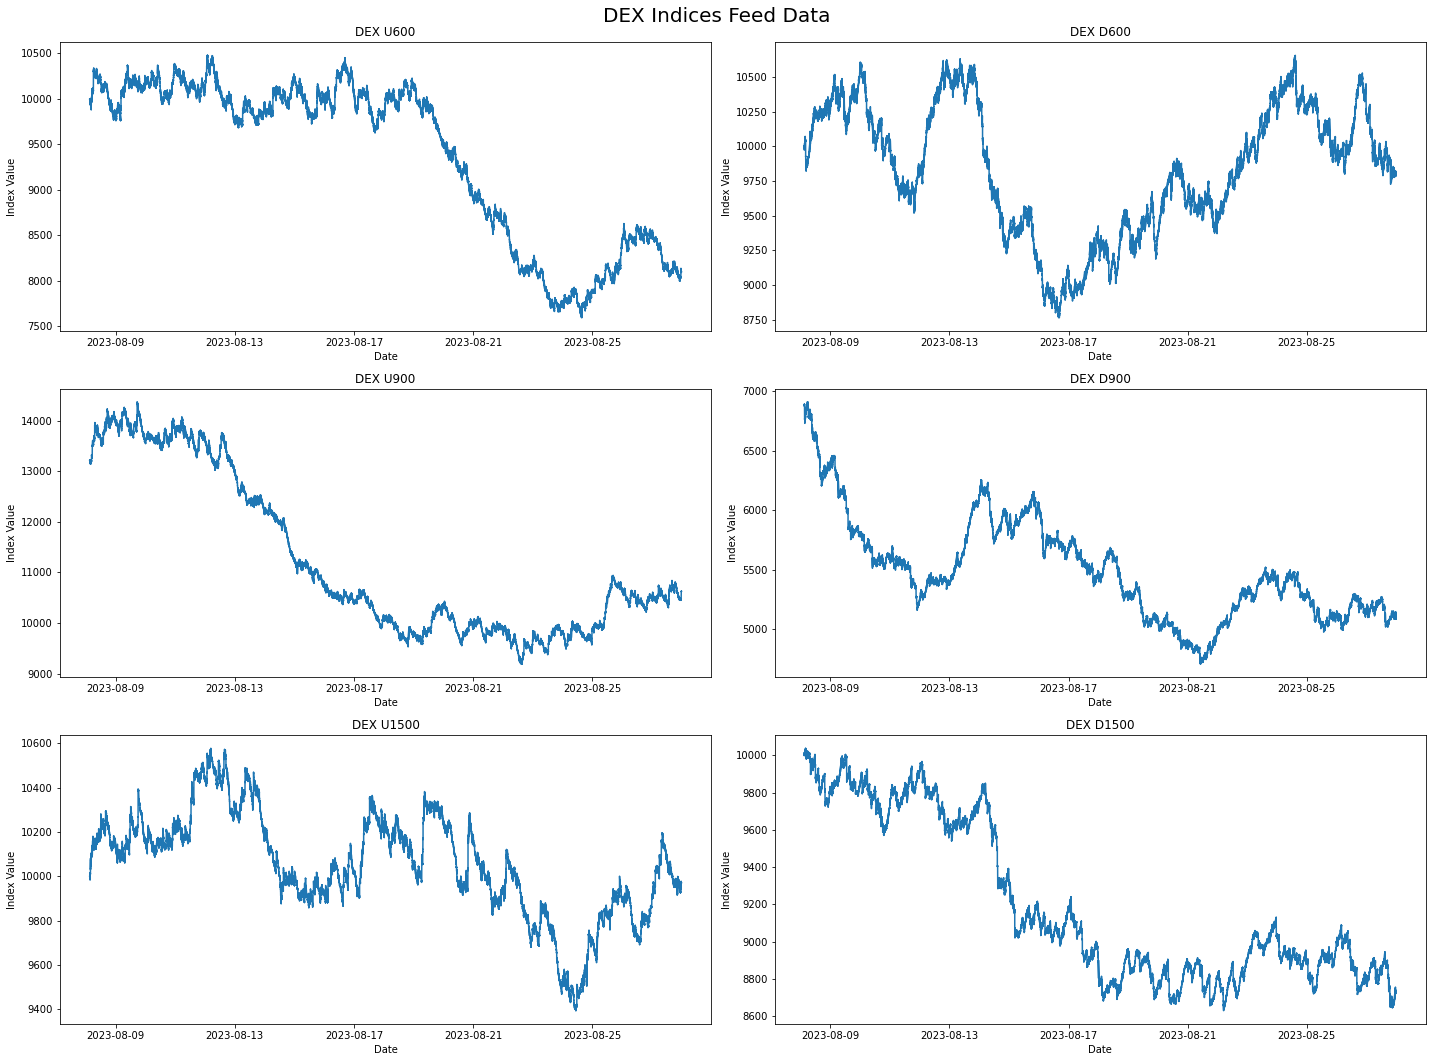

In [4]:
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(20,15))

for i in range(len(dex_down)):

    dex_u = dex_up[i]
    dex_d = dex_down[i]

    ax[i,0].plot(dex_u['ts'],dex_u['spot'])
    ax[i,1].plot(dex_d['ts'],dex_d['spot'])

    ax[i,0].set_xlabel('Date')
    ax[i,0].set_ylabel('Index Value')
    ax[i,1].set_xlabel('Date')
    ax[i,1].set_ylabel('Index Value')

    ax[i,0].set_title(dex_up_name[i])
    ax[i,1].set_title(dex_down_name[i])

    i+=1

plt.suptitle('DEX Indices Feed Data',fontsize=20)

plt.tight_layout()

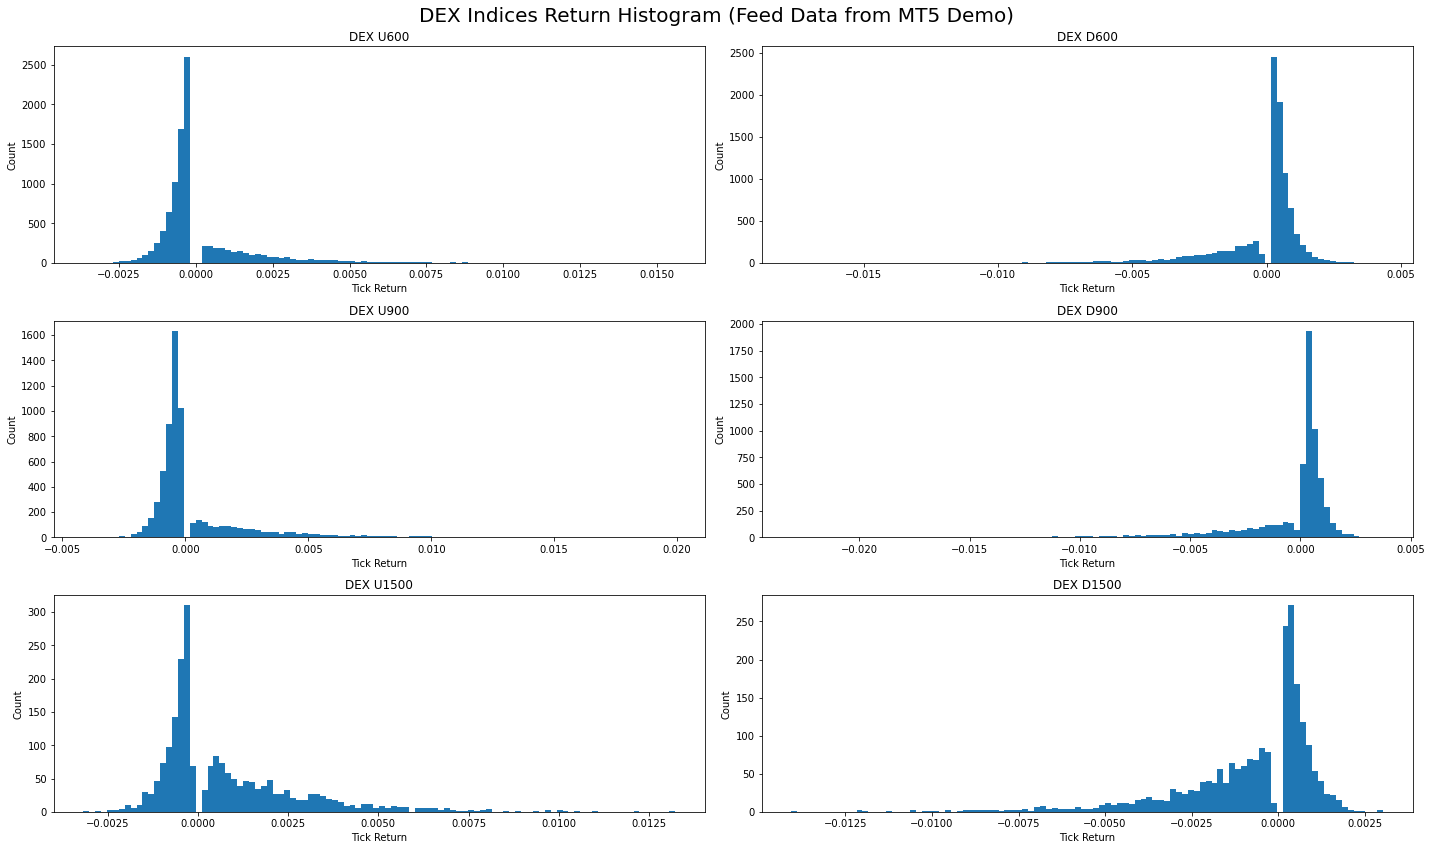

In [5]:
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(20,12))


for i in range(len(dex_down)):

    dex_u = dex_up[i]
    dex_d = dex_down[i]

    ax[i,0].hist(dex_u[abs(dex_u['return'])>0.0002]['return'],bins=100);
    ax[i,1].hist(dex_d[abs(dex_d['return'])>0.0002]['return'],bins=100);

    ax[i,0].set_xlabel('Tick Return')
    ax[i,0].set_ylabel('Count')
    ax[i,1].set_xlabel('Tick Return')
    ax[i,1].set_ylabel('Count')

    ax[i,0].set_title(dex_up_name[i])
    ax[i,1].set_title(dex_down_name[i])

    i+=1

plt.suptitle('DEX Indices Return Histogram (Feed Data from MT5 Demo)',fontsize=20)

plt.tight_layout()

In [23]:
@nb.njit(fastmath=True)
def mgf_jump(q,eta_p,eta_n,t=0):
    return q/(1-t*eta_p)+(1-q)/(1+t*eta_n)

@nb.njit(fastmath=True)
def inv_J_cdf_mv(cdf,q,eta_p,eta_n):
    if cdf<1-q:
        return eta_n*np.log(cdf/(1-q))
    else:
        return-eta_p*np.log((1-cdf)/(q))

@nb.njit(fastmath=True)
def DEX_log_returns(index,n=1000000):
    dt = 1/365/86400
    mu = 0
    vol = 0.25
    decay = 175200
    
    if index == 'DEX U900':
        vol = 0.25
        decay = 175200
        eta_p = 0.30/100
        eta_n = 0.04/100
        q = 0.2
    elif index == 'DEX D900':
        vol = 0.25
        decay = 175200
        eta_p = 0.04/100
        eta_n = 0.30/100
        q = 0.8
    elif index == 'DEX U600':
        vol = 0.2
        decay = 30 * 24 * 365
        eta_p = 0.2/100
        eta_n = 0.04/100
        q = 0.2
    elif index == 'DEX D600':
        vol = 0.2
        decay = 30 * 24 * 365
        eta_p = 0.04/100
        eta_n = 0.20/100
        q = 0.8
    elif index == 'DEX U1500':
        vol = 0.1
        decay = 6 * 24 * 365
        eta_p = 0.2/100
        eta_n = 0.04/100
        q = 0.4
    elif index == 'DEX D1500':
        vol = 0.1
        decay = 6 * 24 * 365
        eta_p = 0.04/100
        eta_n = 0.2/100
        q = 0.6

    a=mgf_jump(q,eta_p,eta_n,t=1)-1

    W = np.zeros(n)
    N = np.zeros(n)
    jumps = np.zeros(n)

    for i in nb.prange(n):
        W[i] = np.random.normal()
        N[i] = np.random.poisson(decay * dt)
    
    for i in range(n):
        jump = 0
        for _ in range(N[i]):
            jump += inv_J_cdf_mv(np.random.uniform(),q,eta_p,eta_n)
            pass
        jumps[i] = jump

    log_S = np.zeros(n+1)

    for i in nb.prange(n):
        log_S[i+1] = (mu-vol**2/2-decay*a)*dt + vol*np.sqrt(dt) * W[i] + jumps[i]
        pass
    return log_S 

@nb.njit(fastmath=True)
def DEX_sim(index, n=1000000):
    S0 = 10000
    log_S = DEX_log_returns(index, n)
    return S0 * np.exp(np.cumsum(log_S))

n=86400*365
S_u600=DEX_sim("DEX U600",n=n)
S_d600=DEX_sim("DEX D600",n=n)
S_u900=DEX_sim("DEX U900",n=n)
S_d900=DEX_sim("DEX D900",n=n)
S_u1500=DEX_sim("DEX U1500",n=n)
S_d1500=DEX_sim("DEX D1500",n=n)

r_u600 = np.log(S_u600[1:]/S_u600[:-1])
r_d600 = np.log(S_d600[1:]/S_d600[:-1])
r_u900 = np.log(S_u900[1:]/S_u900[:-1])
r_d900 = np.log(S_d900[1:]/S_d900[:-1])
r_u1500 = np.log(S_u1500[1:]/S_u1500[:-1])
r_d1500 = np.log(S_d1500[1:]/S_d1500[:-1])


In [42]:
# Calculating Moment from Empirical Data
def emp_moment(index,df,df_moment):
    df_moment.loc[index,'Mean'] = df['return'].mean()
    df_moment.loc[index,'Volatility'] = df['return'].std()*np.sqrt(365*86400)
    df_moment.loc[index,'Skewness'] = skew(df['return'])
    df_moment.loc[index,'Kurtosis'] = kurtosis(df['return'])
    return df_moment

# Calculating Moment from Simulation Data
def true_moment1(df,r_u600,r_d600,r_u900,r_d900,r_u1500,r_d1500):
    
    index = 'DEX U600'
    df.loc[index,'Mean'] = np.mean(r_u600)
    df.loc[index,'Volatility'] = np.std(r_u600)*np.sqrt(365*86400)
    df.loc[index,'Skewness'] = skew(r_u600)
    df.loc[index,'Kurtosis'] = kurtosis(r_u600)

    index = 'DEX D600'
    df.loc[index,'Mean'] = np.mean(r_d600)
    df.loc[index,'Volatility'] = np.std(r_d600)*np.sqrt(365*86400)
    df.loc[index,'Skewness'] = skew(r_d600)
    df.loc[index,'Kurtosis'] = kurtosis(r_d600)

    index = 'DEX U900'
    df.loc[index,'Mean'] = np.mean(r_u900)
    df.loc[index,'Volatility'] = np.std(r_u900)*np.sqrt(365*86400)
    df.loc[index,'Skewness'] = skew(r_u900)
    df.loc[index,'Kurtosis'] = kurtosis(r_u900)

    index = 'DEX D900'
    df.loc[index,'Mean'] = np.mean(r_d900)
    df.loc[index,'Volatility'] = np.std(r_d900)*np.sqrt(365*86400)
    df.loc[index,'Skewness'] = skew(r_d900)
    df.loc[index,'Kurtosis'] = kurtosis(r_d900)

    index = 'DEX U1500'
    df.loc[index,'Mean'] = np.mean(r_u1500)
    df.loc[index,'Volatility'] = np.std(r_u1500)*np.sqrt(365*86400)
    df.loc[index,'Skewness'] = skew(r_u1500)
    df.loc[index,'Kurtosis'] = kurtosis(r_u1500)

    index = 'DEX D1500'
    df.loc[index,'Mean'] = np.mean(r_d1500)
    df.loc[index,'Volatility'] = np.std(r_d1500)*np.sqrt(365*86400)
    df.loc[index,'Skewness'] = skew(r_d1500)
    df.loc[index,'Kurtosis'] = kurtosis(r_d1500)

    return df


def true_moment(df,index):

    if index == 'DEX U900':
        params = [0.25,175200,0.20,0.30/100,0.04/100]

    elif index == 'DEX D900':
        params = [0.25,175200,0.80,0.04/100,0.30/100]

    elif index == 'DEX U600':
        params = [0.20,262800,0.20,0.20/100,0.04/100]

    elif index == 'DEX D600':
        params = [0.20,262800,0.80,0.04/100,0.20/100]

    elif index == 'DEX U1500':
        params = [0.10,52560,0.40,0.20/100,0.04/100]

    elif index == 'DEX D1500':
        params = [0.10,52560,0.60,0.04/100,0.20/100]

    dt=1/365/86400
    vol = params[0]
    lam = params[1]
    q = params[2]
    eta_p = params[3]
    eta_n = params[4]
    a = mgf_jump(q,eta_p,eta_n,t=1)-1

    p=1-q

    df.loc[index,'Mean'] =  -0.5*vol**2*dt-lam*dt*a + lam*dt*(q*eta_p-p*eta_n)
    variance = vol**2*dt + 2*(lam*dt)*(q*eta_p**2+p*eta_n**2)
    df.loc[index,'Volatility'] =np.sqrt(variance*365*86400)
    

    df.loc[index,'Skewness'] = lam*dt*factorial(3)*((-1)**(3)*p*eta_n**(3)+q*eta_p**(3))/(variance**(3/2))
    df.loc[index,'Kurtosis'] = lam*dt*factorial(4)*((-1)**(4)*p*eta_n**(4)+q*eta_p**(4))/(variance**(4/2))

    return df




#### Moment Matching on Demo Data only

In [45]:
demo_time = "2023-08-17 08:07:12"
df_feed = pd.DataFrame(index=['DEX U600','DEX U900','DEX U1500','DEX D600','DEX D900','DEX D1500'],columns = ['Mean','Volatility','Skewness','Kurtosis'])

df_feed = emp_moment('DEX U600',dex_u600[dex_u600['ts']>=demo_time],df_feed)
df_feed = emp_moment('DEX D600',dex_d600[dex_d600['ts']>=demo_time],df_feed)
df_feed = emp_moment('DEX U900',dex_u900[dex_u900['ts']>=demo_time],df_feed)
df_feed = emp_moment('DEX D900',dex_d900[dex_d900['ts']>=demo_time],df_feed)
df_feed = emp_moment('DEX U1500',dex_u1500[dex_u1500['ts']>=demo_time],df_feed)
df_feed = emp_moment('DEX D1500',dex_d1500[dex_d1500['ts']>=demo_time],df_feed)

df_true = pd.DataFrame(index=['DEX U600','DEX U900','DEX U1500','DEX D600','DEX D900','DEX D1500'],columns = ['Mean','Volatility','Skewness','Kurtosis'])

for index in dex_up_name:
    df_true = true_moment(df_true,index)

for index in dex_down_name:
    df_true = true_moment(df_true,index)

df_diff_abs = df_feed-df_true
df_diff_rel = df_feed/df_true -1

pd.set_option("display.precision", 8)
display_side_by_side(df_feed,df_true,df_diff_abs,df_diff_rel,titles=['Feed Data Moments (Demo Data Only)','True Moments','Difference (abs)','Difference (rel)'])

,Mean,Volatility,Skewness,Kurtosis
DEX U600,-0.00000023,0.7170031,35.31630485,2274.90286739
DEX U900,-0.0,0.84538755,45.34611457,3078.70298327
DEX U1500,-0.00000003,0.41067984,61.2558964,5526.80111483
DEX D600,0.00000009,0.73754885,-37.32891679,2531.47848478
DEX D900,-0.00000011,0.88492772,-50.08588895,3986.17025176
DEX D1500,-0.00000004,0.43067356,-64.56591485,6360.34516846
,Mean,Volatility,Skewness,Kurtosis
DEX U600,-0.00000001,0.72646872,35.77045777,2299.83214784
DEX U900,-0.00000001,0.8591107,49.79636322,3948.38173166
DEX U1500,-0.0,0.43391649,68.53278328,7198.95765976



#### Moment Matching on Dev Data only

In [46]:
demo_time = "2023-08-17 08:07:12"
df_feed = pd.DataFrame(index=['DEX U600','DEX U900','DEX U1500','DEX D600','DEX D900','DEX D1500'],columns = ['Mean','Volatility','Skewness','Kurtosis'])

df_feed = emp_moment('DEX U600',dex_u600[dex_u600['ts']<demo_time],df_feed)
df_feed = emp_moment('DEX D600',dex_d600[dex_d600['ts']<demo_time],df_feed)
df_feed = emp_moment('DEX U900',dex_u900[dex_u900['ts']<demo_time],df_feed)
df_feed = emp_moment('DEX D900',dex_d900[dex_d900['ts']<demo_time],df_feed)
df_feed = emp_moment('DEX U1500',dex_u1500[dex_u1500['ts']<demo_time],df_feed)
df_feed = emp_moment('DEX D1500',dex_d1500[dex_d1500['ts']<demo_time],df_feed)

df_true = pd.DataFrame(index=['DEX U600','DEX U900','DEX U1500','DEX D600','DEX D900','DEX D1500'],columns = ['Mean','Volatility','Skewness','Kurtosis'])
# df_true = true_moment(df_true,r_u600,r_d600,r_u900,r_d900,r_u1500,r_d1500)

for index in dex_up_name:
    df_true = true_moment(df_true,index)

for index in dex_down_name:
    df_true = true_moment(df_true,index)

df_diff_abs = df_feed-df_true
df_diff_rel = df_feed/df_true -1

pd.set_option("display.precision", 8)
display_side_by_side(df_feed,df_true,df_diff_abs,df_diff_rel,titles=['Feed Data Moments (Dev Data Only)','True Moments','Difference (abs)','Difference (rel)'])

,Mean,Volatility,Skewness,Kurtosis
DEX U600,0.00000001,0.71840268,33.49477552,1965.20294821
DEX U900,-0.00000027,0.82993469,50.84547655,4102.38097316
DEX U1500,0.00000003,0.44320585,63.75175625,5996.42428316
DEX D600,-0.00000013,0.72896899,-33.43859023,1870.90422005
DEX D900,-0.00000025,0.88905901,-47.03864814,3373.85873422
DEX D1500,-0.00000013,0.47867262,-66.22513957,5992.897288
,Mean,Volatility,Skewness,Kurtosis
DEX U600,-0.00000001,0.72646872,35.77045777,2299.83214784
DEX U900,-0.00000001,0.8591107,49.79636322,3948.38173166
DEX U1500,-0.0,0.43391649,68.53278328,7198.95765976



#### Moment Matching on Combined Data

In [47]:
df_feed = pd.DataFrame(index=['DEX U600','DEX U900','DEX U1500','DEX D600','DEX D900','DEX D1500'],columns = ['Mean','Volatility','Skewness','Kurtosis'])
df_feed = emp_moment('DEX U600',dex_u600,df_feed)
df_feed = emp_moment('DEX D600',dex_d600,df_feed)
df_feed = emp_moment('DEX U900',dex_u900,df_feed)
df_feed = emp_moment('DEX D900',dex_d900,df_feed)
df_feed = emp_moment('DEX U1500',dex_u1500,df_feed)
df_feed = emp_moment('DEX D1500',dex_d1500,df_feed)

df_true = pd.DataFrame(index=['DEX U600','DEX U900','DEX U1500','DEX D600','DEX D900','DEX D1500'],columns = ['Mean','Volatility','Skewness','Kurtosis'])
# df_true = true_moment(df_true,r_u600,r_d600,r_u900,r_d900,r_u1500,r_d1500)

for index in dex_up_name:
    df_true = true_moment(df_true,index)

for index in dex_down_name:
    df_true = true_moment(df_true,index)

df_diff_abs = df_feed-df_true
df_diff_rel = df_feed/df_true -1

pd.set_option("display.precision", 8)
display_side_by_side(df_feed,df_true,df_diff_abs,df_diff_rel,titles=['Feed Data Moments (Combined)','True Moments','Difference (abs)','Difference (rel)'])

,Mean,Volatility,Skewness,Kurtosis
DEX U600,-0.00000012,0.71765247,34.46910274,2130.70946432
DEX U900,-0.00000013,0.83825829,47.82644862,3535.79249721
DEX U1500,-0.0,0.42606943,62.69202013,5813.94411069
DEX D600,-0.00000001,0.73358329,-35.5608073,2233.16634786
DEX D900,-0.00000017,0.88684544,-48.66281382,3699.50689559
DEX D1500,-0.00000008,0.45356051,-65.74089934,6220.25237644
,Mean,Volatility,Skewness,Kurtosis
DEX U600,-0.00000001,0.72646872,35.77045777,2299.83214784
DEX U900,-0.00000001,0.8591107,49.79636322,3948.38173166
DEX U1500,-0.0,0.43391649,68.53278328,7198.95765976


### Section 2

Here we check the parameters backward engineering from the feed data moments.

The result is highly dependable on the initial and boundary condition. The difference in the results are acceptable.

In [11]:
def eq_moment(params,n):
    dt=1/365/86400
    vol = params[0]
    lam = params[1]
    q = params[2]
    eta_p = params[3]
    eta_n = params[4]
    a = mgf_jump(q,eta_p,eta_n,t=1)-1

    p=1-q

    if n==1:
        result = -0.5*vol**2*dt-lam*dt*a + lam*dt*(q*eta_p-p*eta_n)
    elif n==2:
        result = vol**2*dt + 2*(lam*dt)*(q*eta_p**2+p*eta_n**2)
    else:
        variance = vol**2*dt + 2*(lam*dt)*(q*eta_p**2+p*eta_n**2)
        result = lam*dt*factorial(n)*((-1)**(n)*p*eta_n**(n)+q*eta_p**(n))/(variance**(n/2))
    return result

def func(params,moments):
    eq =[eq_moment(params,1) - moments[0], eq_moment(params,2) - moments[1], eq_moment(params,3) - moments[2], eq_moment(params,4) - moments[3], eq_moment(params,5) - moments[4]]
    result = np.sum(np.power(eq,2))
    return result

def params_solve(index,df):
    # Get the target
    moment_1 = np.mean(df['return']**1)
    moment_2 = np.mean((df['return']-moment_1)**2)
    moment_3 = np.mean((df['return']-moment_1)**3)/moment_2**(3/2)
    moment_4 = np.mean((df['return']-moment_1)**4)/moment_2**(4/2)
    moment_5 = np.mean((df['return']-moment_1)**5)/moment_2**(5/2)
    moment_6 = np.mean((df['return']-moment_1)**6)/moment_2**(6/2)

    moments = [moment_1,moment_2,moment_3,moment_4,moment_5,moment_6]

    # Solve for the unknown parameters
    if index == 'DEX U900':
        params_guess = [0.25,175200,0.20,0.30/100,0.04/100]

    elif index == 'DEX D900':
        params_guess = [0.25,175200,0.80,0.04/100,0.30/100]

    elif index == 'DEX U600':
        params_guess = [0.20,262800,0.20,0.20/100,0.04/100]
    
    elif index == 'DEX D600':
        params_guess = [0.20,262800,0.80,0.04/100,0.20/100]

    elif index == 'DEX U1500':
        params_guess = [0.10,52560,0.40,0.20/100,0.04/100]

    elif index == 'DEX D1500':
        params_guess = [0.10,52560,0.60,0.04/100,0.20/100]


    params_guess = np.multiply(params_guess,0.97)

    bound = 0.025
    bounds = []
    for params in params_guess:
        bounds.append((params*(1-bound),params*(1+bound)))

    result = minimize(func,params_guess,bounds=bounds,args=(moments))
    params_solve = result.x
    return params_solve


df_params_feed = pd.DataFrame(index=['DEX U600','DEX U900','DEX U1500','DEX D600','DEX D900','DEX D1500'],columns = ['Vol','Lambda','Probability','Positive Eta','Negative Eta'])


for i in range(len(dex_up_name)):
    index_name = dex_up_name[i]
    df = dex_up[i]
    dex_params = params_solve(index_name,df)
    df_params_feed.loc[index_name,'Vol'] = dex_params[0]
    df_params_feed.loc[index_name,'Lambda'] = dex_params[1]
    df_params_feed.loc[index_name,'Probability'] = dex_params[2]
    df_params_feed.loc[index_name,'Positive Eta'] = dex_params[3]
    df_params_feed.loc[index_name,'Negative Eta'] = dex_params[4]

for i in range(len(dex_down_name)):
    index_name = dex_down_name[i]
    df = dex_down[i]
    dex_params = params_solve(index_name,df)
    df_params_feed.loc[index_name,'Vol'] = dex_params[0]
    df_params_feed.loc[index_name,'Lambda'] = dex_params[1]
    df_params_feed.loc[index_name,'Probability'] = dex_params[2]
    df_params_feed.loc[index_name,'Positive Eta'] = dex_params[3]
    df_params_feed.loc[index_name,'Negative Eta'] = dex_params[4]

df_params_true = pd.DataFrame(index=['DEX U600','DEX U900','DEX U1500','DEX D600','DEX D900','DEX D1500'],columns = ['Vol','Lambda','Probability','Positive Eta','Negative Eta'])

df_params_true.loc['DEX U900','Vol'] = 0.25
df_params_true.loc['DEX U900','Lambda'] = 175200
df_params_true.loc['DEX U900','Probability'] = 0.2
df_params_true.loc['DEX U900','Positive Eta'] = 0.3/100
df_params_true.loc['DEX U900','Negative Eta'] = 0.04/100

df_params_true.loc['DEX D900','Vol'] = 0.25
df_params_true.loc['DEX D900','Lambda'] = 175200
df_params_true.loc['DEX D900','Probability'] = 0.8
df_params_true.loc['DEX D900','Positive Eta'] = 0.04/100
df_params_true.loc['DEX D900','Negative Eta'] =  0.3/100

df_params_true.loc['DEX U600','Vol'] = 0.20
df_params_true.loc['DEX U600','Lambda'] = 30*365*24
df_params_true.loc['DEX U600','Probability'] = 0.2
df_params_true.loc['DEX U600','Positive Eta'] = 0.2/100
df_params_true.loc['DEX U600','Negative Eta'] = 0.04/100

df_params_true.loc['DEX D600','Vol'] = 0.20
df_params_true.loc['DEX D600','Lambda'] = 30*365*24
df_params_true.loc['DEX D600','Probability'] = 0.8
df_params_true.loc['DEX D600','Positive Eta'] = 0.04/100
df_params_true.loc['DEX D600','Negative Eta'] =  0.2/100

df_params_true.loc['DEX U1500','Vol'] = 0.10
df_params_true.loc['DEX U1500','Lambda'] = 6*365*24
df_params_true.loc['DEX U1500','Probability'] = 0.4
df_params_true.loc['DEX U1500','Positive Eta'] = 0.2/100
df_params_true.loc['DEX U1500','Negative Eta'] = 0.04/100

df_params_true.loc['DEX D1500','Vol'] = 0.10
df_params_true.loc['DEX D1500','Lambda'] = 6*365*24
df_params_true.loc['DEX D1500','Probability'] = 0.6
df_params_true.loc['DEX D1500','Positive Eta'] = 0.04/100
df_params_true.loc['DEX D1500','Negative Eta'] =  0.2/100

df_params_diff = df_params_feed/df_params_true-1

pd.set_option("display.precision", 8)
display_side_by_side(df_params_feed,df_params_true,df_params_diff,titles=['Feed Data Params','True Params','Difference (rel)'])

,Vol,Lambda,Probability,Positive Eta,Negative Eta
DEX U600,0.19885,261288.9,0.19885,0.0018915,0.0003977
DEX U900,0.2485625,174192.6,0.19885,0.00283725,0.0003977
DEX U1500,0.099425,52257.78,0.3977,0.0018915,0.0003977
DEX D600,0.19495306,254922.5395474,0.77218777,0.0003783,0.00192919
DEX D900,0.24402909,171015.585434,0.77110692,0.00039048,0.00289164
DEX D1500,0.099425,52257.78,0.56745,0.0003977,0.0018915
,Vol,Lambda,Probability,Positive Eta,Negative Eta
DEX U600,0.2,262800,0.2,0.002,0.0004
DEX U900,0.25,175200,0.2,0.003,0.0004
DEX U1500,0.1,52560,0.4,0.002,0.0004


### Section 3

We want to check the convergence speed of the DEX feed data in term of the moments.

Overall looks fine.

In [68]:
def eq_moment1(index,n):

    if index == 'DEX U900':
        params = [0.25,175200,0.20,0.30/100,0.04/100]

    elif index == 'DEX D900':
        params = [0.25,175200,0.80,0.04/100,0.30/100]

    elif index == 'DEX U600':
        params = [0.20,262800,0.20,0.20/100,0.04/100]

    elif index == 'DEX D600':
        params = [0.20,262800,0.80,0.04/100,0.20/100]

    elif index == 'DEX U1500':
        params = [0.10,52560,0.40,0.20/100,0.04/100]

    elif index == 'DEX D1500':
        params = [0.10,52560,0.60,0.04/100,0.20/100]

    dt=1/365/86400
    vol = params[0]
    lam = params[1]
    q = params[2]
    eta_p = params[3]
    eta_n = params[4]
    a = mgf_jump(q,eta_p,eta_n,t=1)-1

    p=1-q

    if n==1:
        result = -0.5*vol**2*dt-lam*dt*a + lam*dt*(q*eta_p-p*eta_n)
    elif n==2:
        result =np.sqrt( (vol**2*dt + 2*(lam*dt)*(q*eta_p**2+p*eta_n**2))*(1/dt))
    else:
        variance = vol**2*dt + 2*(lam*dt)*(q*eta_p**2+p*eta_n**2)
        result = lam*dt*factorial(n)*((-1)**(n)*p*eta_n**(n)+q*eta_p**(n))/(variance**(n/2))

    return result

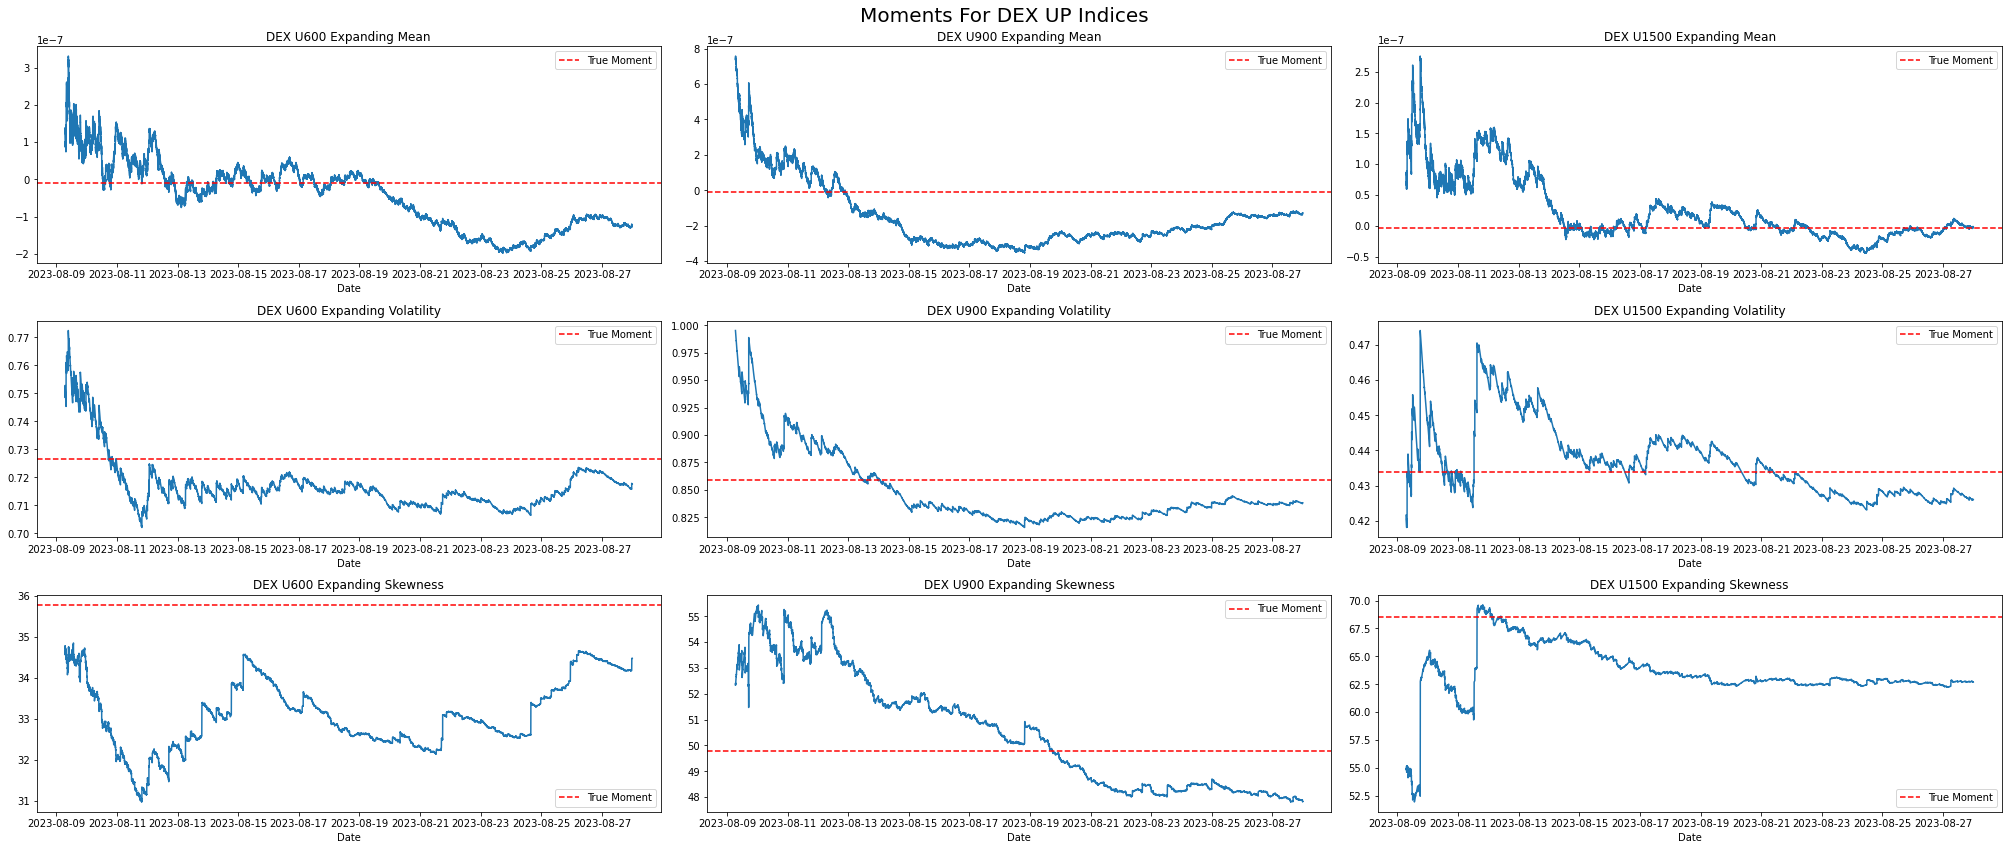

In [69]:
gap = 100_000
dex_u600['expanding_mean'] =dex_u600['return'].expanding(gap).mean()
dex_u600['expanding_vol'] =dex_u600['return'].expanding(gap).std()* np.sqrt(365*86400)
dex_u600['expanding_skew'] =dex_u600['return'].expanding(gap).skew()

dex_d600['expanding_mean'] =dex_d600['return'].expanding(gap).mean()
dex_d600['expanding_vol'] =dex_d600['return'].expanding(gap).std()* np.sqrt(365*86400)
dex_d600['expanding_skew'] =dex_d600['return'].expanding(gap).skew()

dex_u900['expanding_mean'] =dex_u900['return'].expanding(gap).mean()
dex_u900['expanding_vol'] =dex_u900['return'].expanding(gap).std()* np.sqrt(365*86400)
dex_u900['expanding_skew'] =dex_u900['return'].expanding(gap).skew()

dex_d900['expanding_mean'] =dex_d900['return'].expanding(gap).mean()
dex_d900['expanding_vol'] =dex_d900['return'].expanding(gap).std()* np.sqrt(365*86400)
dex_d900['expanding_skew'] =dex_d900['return'].expanding(gap).skew()

dex_u1500['expanding_mean'] =dex_u1500['return'].expanding(gap).mean()
dex_u1500['expanding_vol'] =dex_u1500['return'].expanding(gap).std()* np.sqrt(365*86400)
dex_u1500['expanding_skew'] =dex_u1500['return'].expanding(gap).skew()

dex_d1500['expanding_mean'] =dex_d1500['return'].expanding(gap).mean()
dex_d1500['expanding_vol'] =dex_d1500['return'].expanding(gap).std()* np.sqrt(365*86400)
dex_d1500['expanding_skew'] =dex_d1500['return'].expanding(gap).skew()


fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(28,12))

for i in range(len(dex_up_name)):
    df= dex_up[i]
    index_name = dex_up_name[i]

    ax[0,i].plot(df['ts'],df['expanding_mean'])
    ax[1,i].plot(df['ts'],df['expanding_vol'])
    ax[2,i].plot(df['ts'],df['expanding_skew'])


    ax[0,i].set_title(f'{index_name} Expanding Mean')
    ax[1,i].set_title(f'{index_name} Expanding Volatility')
    ax[2,i].set_title(f'{index_name} Expanding Skewness')

    moment = eq_moment1(index_name,1)
    ax[0,i].axhline(moment,color='red',label='True Moment',linestyle='dashed')

    moment = eq_moment1(index_name,2)
    ax[1,i].axhline(moment,color='red',label='True Moment',linestyle='dashed')

    moment = eq_moment1(index_name,3)
    ax[2,i].axhline(moment,color='red',label='True Moment',linestyle='dashed')

    for j in range(3):
        ax[j,i].set_xlabel('Date')
        ax[j,i].legend()

plt.suptitle("Moments For DEX UP Indices", fontsize=20)
plt.tight_layout()


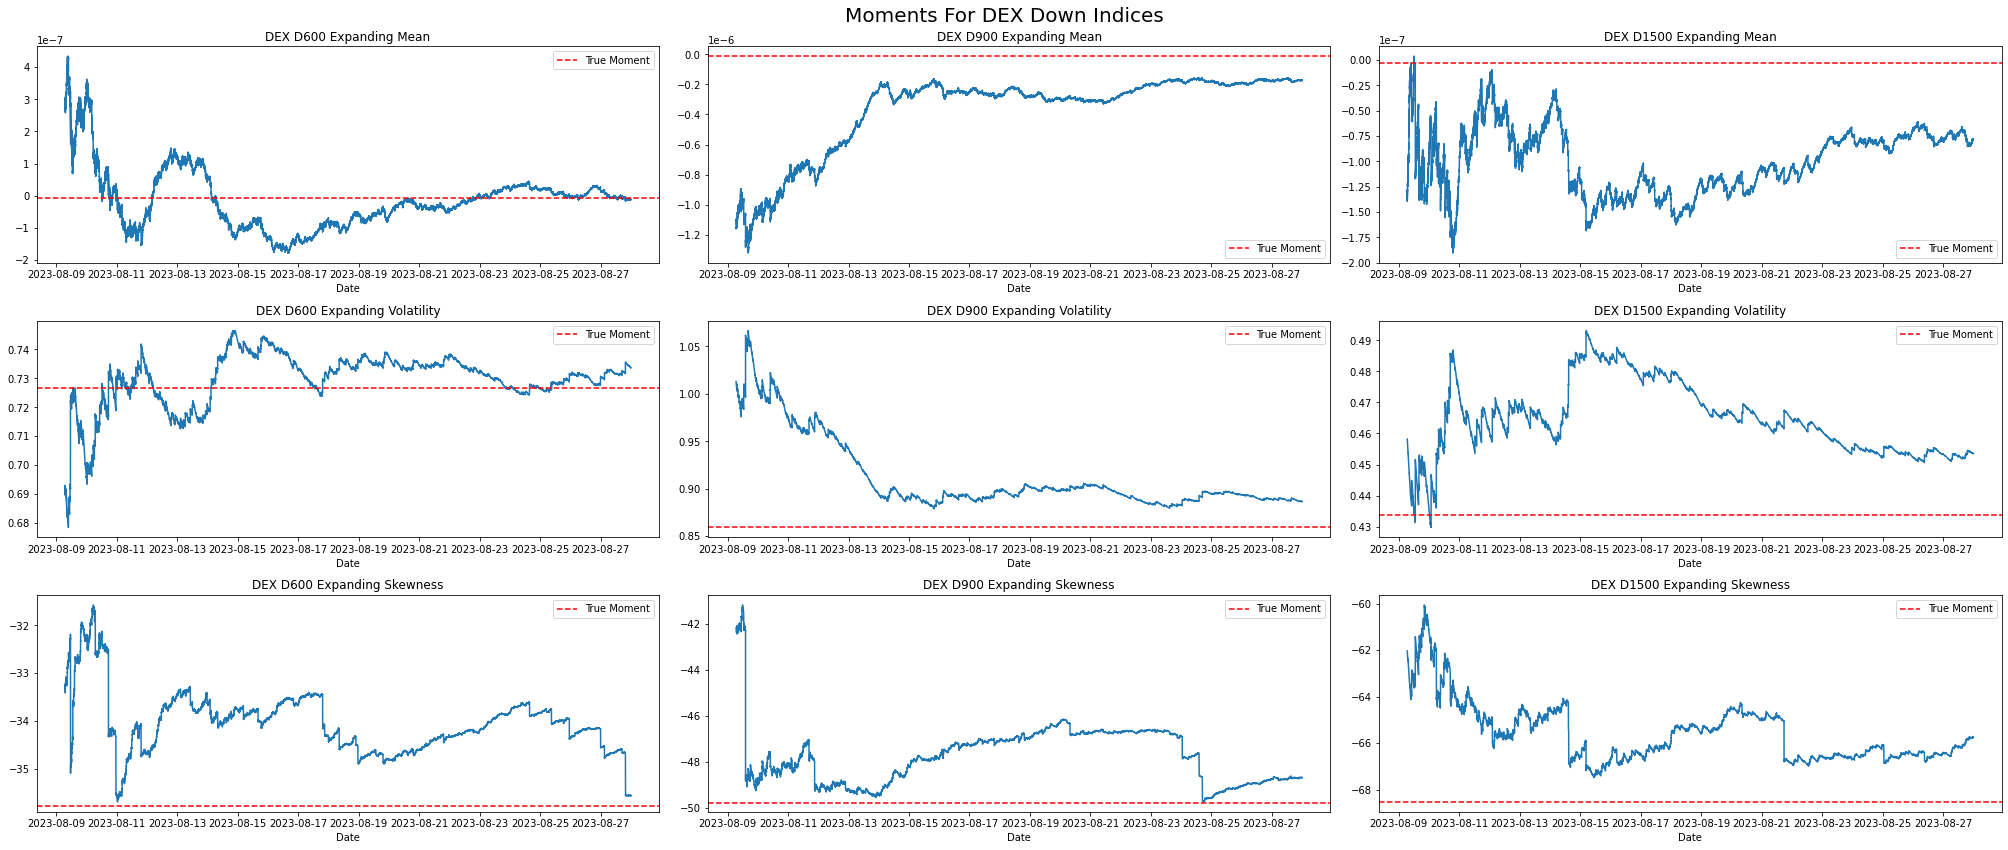

In [71]:

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(28,12))


for i in range(len(dex_down_name)):
    df= dex_down[i]
    index_name = dex_down_name[i]

    ax[0,i].plot(df['ts'],df['expanding_mean'])
    ax[1,i].plot(df['ts'],df['expanding_vol'])
    ax[2,i].plot(df['ts'],df['expanding_skew'])


    ax[0,i].set_title(f'{index_name} Expanding Mean')
    ax[1,i].set_title(f'{index_name} Expanding Volatility')
    ax[2,i].set_title(f'{index_name} Expanding Skewness')

    moment = eq_moment1(index_name,1)
    ax[0,i].axhline(moment,color='red',label='True Moment',linestyle='dashed')

    moment = eq_moment1(index_name,2)
    ax[1,i].axhline(moment,color='red',label='True Moment',linestyle='dashed')

    moment = eq_moment1(index_name,3)
    ax[2,i].axhline(moment,color='red',label='True Moment',linestyle='dashed')

    for j in range(3):
        ax[j,i].set_xlabel('Date')
        ax[j,i].legend()    

        
plt.suptitle("Moments For DEX Down Indices", fontsize=20)
plt.tight_layout()

### Section 4

The simulation steps of the strategy testing are:
1. Run 3-months simulation for DEX Down 600/900/1500. Up indices is not run because it is just opposite direction.
2. Run the trading strategy on the simulation data.
   1. Define the jump size same as the negative eta.
   2. After each jump, wait for mean jump frequency (which is 600/900/1500 seconds respectively). If there is no jump, enter into a short position.
   3. Enter into additional short position every mean jump frequency if there is no jump.
   4. Exit all positions in next jump.
3. Repeat the strategy for a sufficient number of times. In here, it is 10K.
4. Plot the average PnL%, Hit Ratio and Win Rate.

In total there are 3 variations of this strategies are run too, which is to:
1. Waiting time and additional position frequency same as mean jump frequency.
2. Waiting time same as mean jump frequency but additional position frequency at 5 mins.
3. Double the waiting time and enter into additional positions every 5 mins.

Key points to conclude the strategy testing:
1. Mean Hit Ratio of 50% shows that the exploitation is not possible.
2. Mean Win Rate of 60% is expected due to the clear pattern of the index.
3. Spread of 0.01% is sufficient for DEX 900 as it covers the mean and median of the strategy PnL in %.
4. The strategy also shows that the spread of DEX 600/1500 can be lower than DEX 900, and as low as 50%. After discussion with Antoine, 75% of DEX 900 Spread will be the go-live decision.

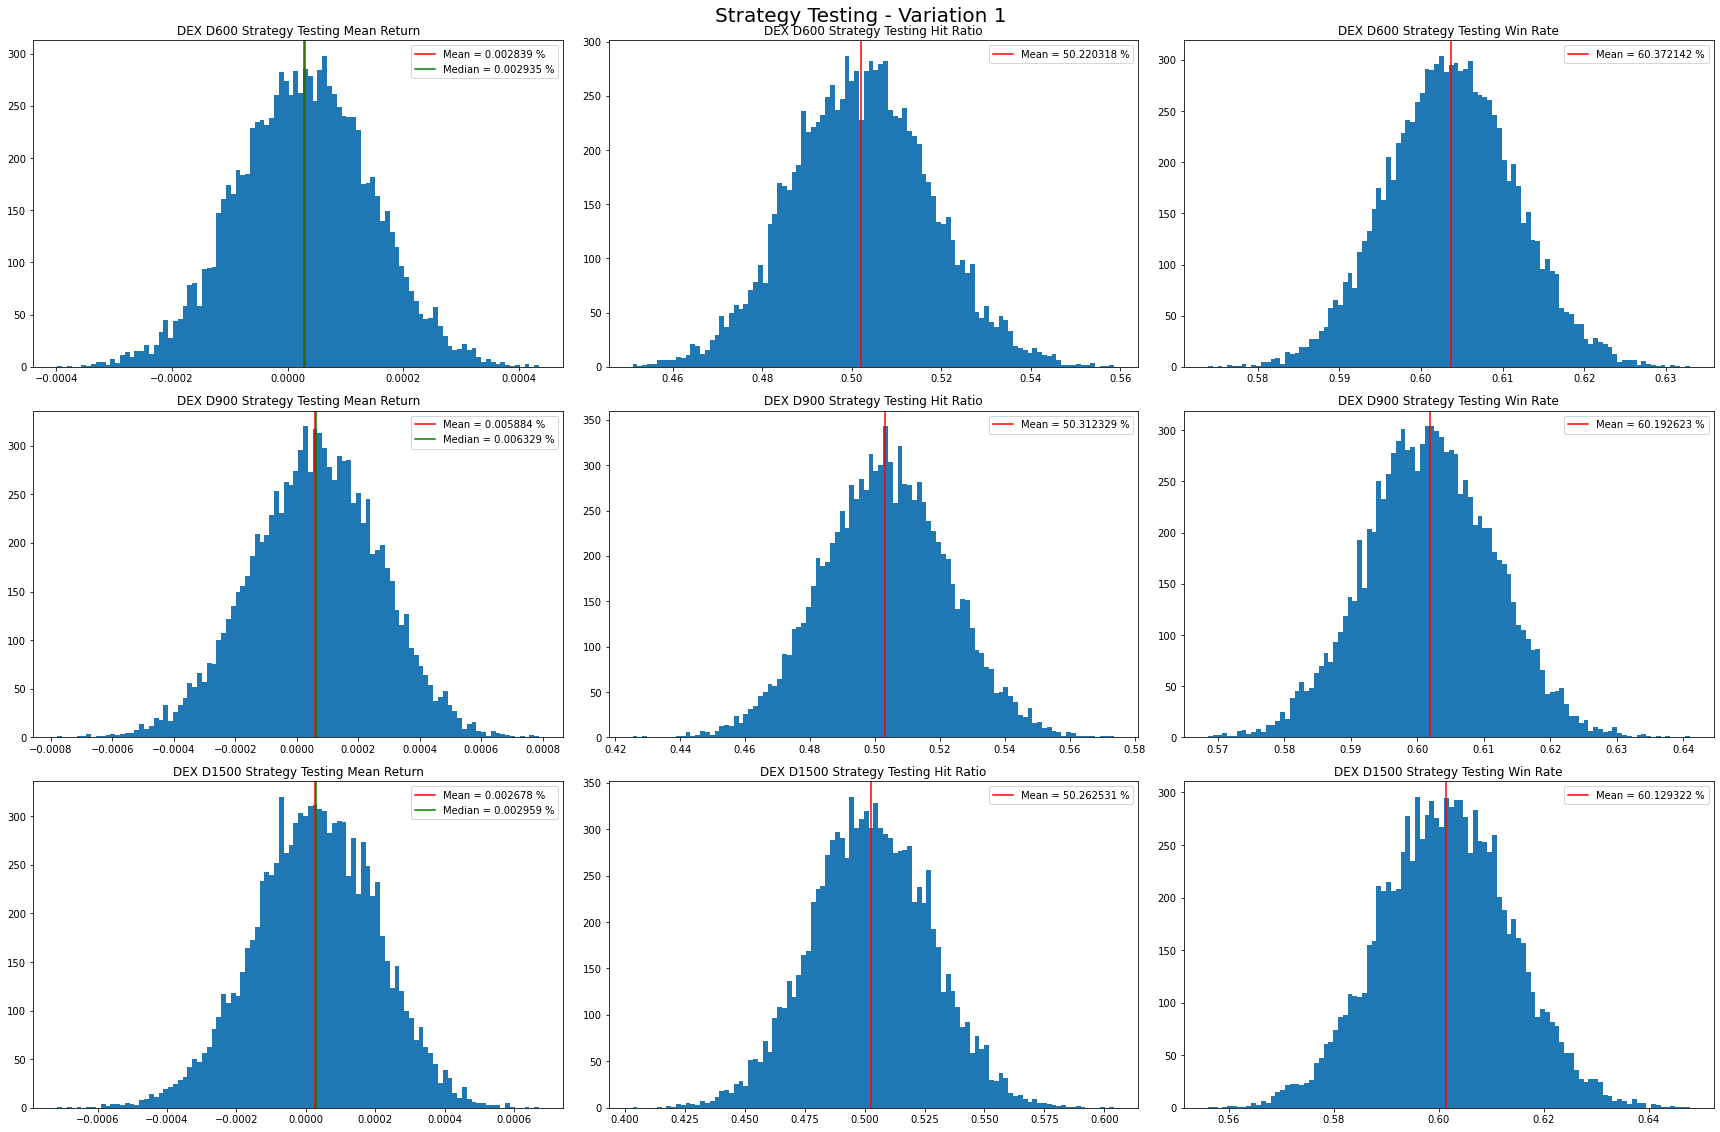

In [15]:
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(24,16))
i=0

strategy_result = pd.read_csv("3M_strategy_same_interval.csv")
for index in dex_down_name:

    # Mean Return
    df_plot = strategy_result[strategy_result['index']==index]['Mean Return']
    ax[i,0].hist(df_plot,bins=100)
    ax[i,0].set_title(f"{index} Strategy Testing Mean Return")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,0].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,0].axvline(median_return,color='green',label = f"Median = {median_return*100:.6f} %")
    ax[i,0].legend()

    # Hit Ratio
    df_plot = strategy_result[strategy_result['index']==index]['Hit Ratio']
    ax[i,1].hist(df_plot,bins=100)
    ax[i,1].set_title(f"{index} Strategy Testing Hit Ratio")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,1].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,1].legend()

    # Win Rate 
    df_plot = strategy_result[strategy_result['index']==index]['Win Rate']
    ax[i,2].hist(df_plot,bins=100)
    ax[i,2].set_title(f"{index} Strategy Testing Win Rate")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,2].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,2].legend()
    
    i+=1

plt.suptitle("Strategy Testing - Variation 1",fontsize=20);
plt.tight_layout();



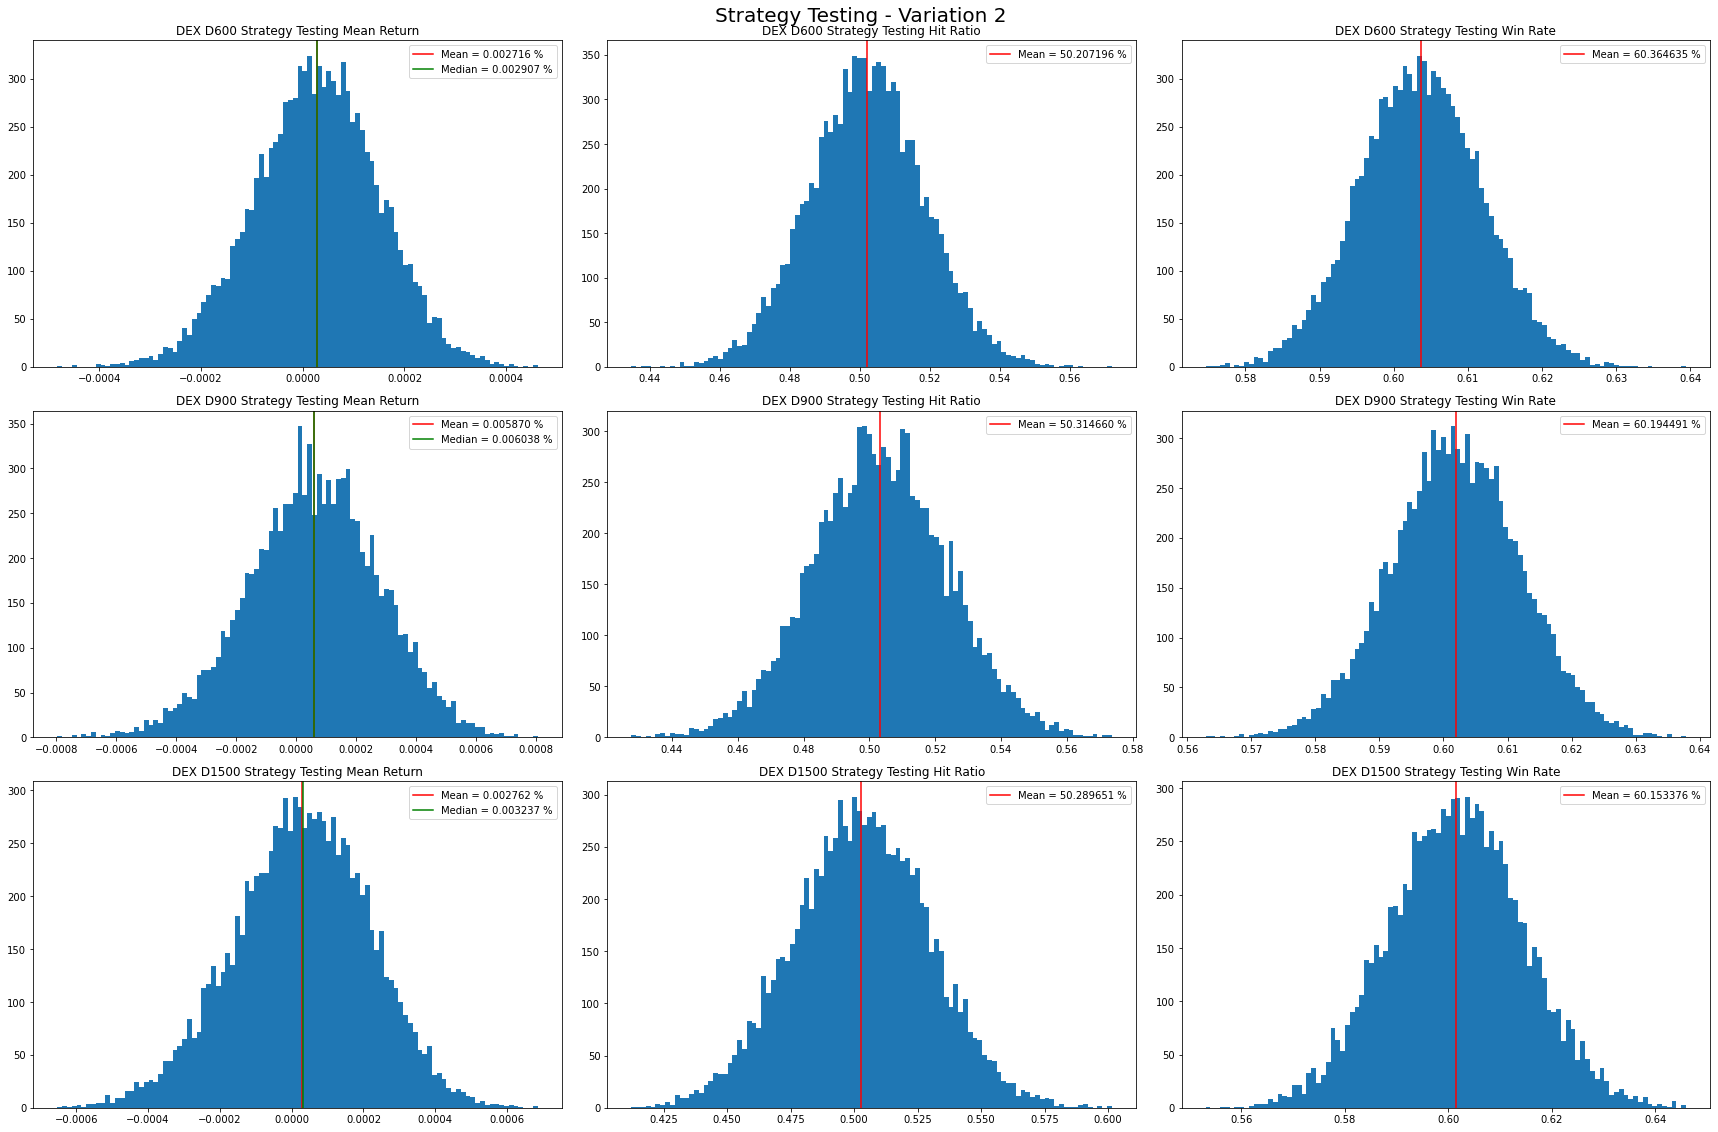

In [16]:
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(24,16))
i=0

strategy_result = pd.read_csv("3M_strategy_low_interval.csv")
for index in dex_down_name:

    # Mean Return
    df_plot = strategy_result[strategy_result['index']==index]['Mean Return']
    ax[i,0].hist(df_plot,bins=100)
    ax[i,0].set_title(f"{index} Strategy Testing Mean Return")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,0].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,0].axvline(median_return,color='green',label = f"Median = {median_return*100:.6f} %")
    ax[i,0].legend()

    # Hit Ratio
    df_plot = strategy_result[strategy_result['index']==index]['Hit Ratio']
    ax[i,1].hist(df_plot,bins=100)
    ax[i,1].set_title(f"{index} Strategy Testing Hit Ratio")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,1].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,1].legend()

    # Win Rate 
    df_plot = strategy_result[strategy_result['index']==index]['Win Rate']
    ax[i,2].hist(df_plot,bins=100)
    ax[i,2].set_title(f"{index} Strategy Testing Win Rate")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,2].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,2].legend()
    
    i+=1

plt.suptitle("Strategy Testing - Variation 2",fontsize=20);
plt.tight_layout();


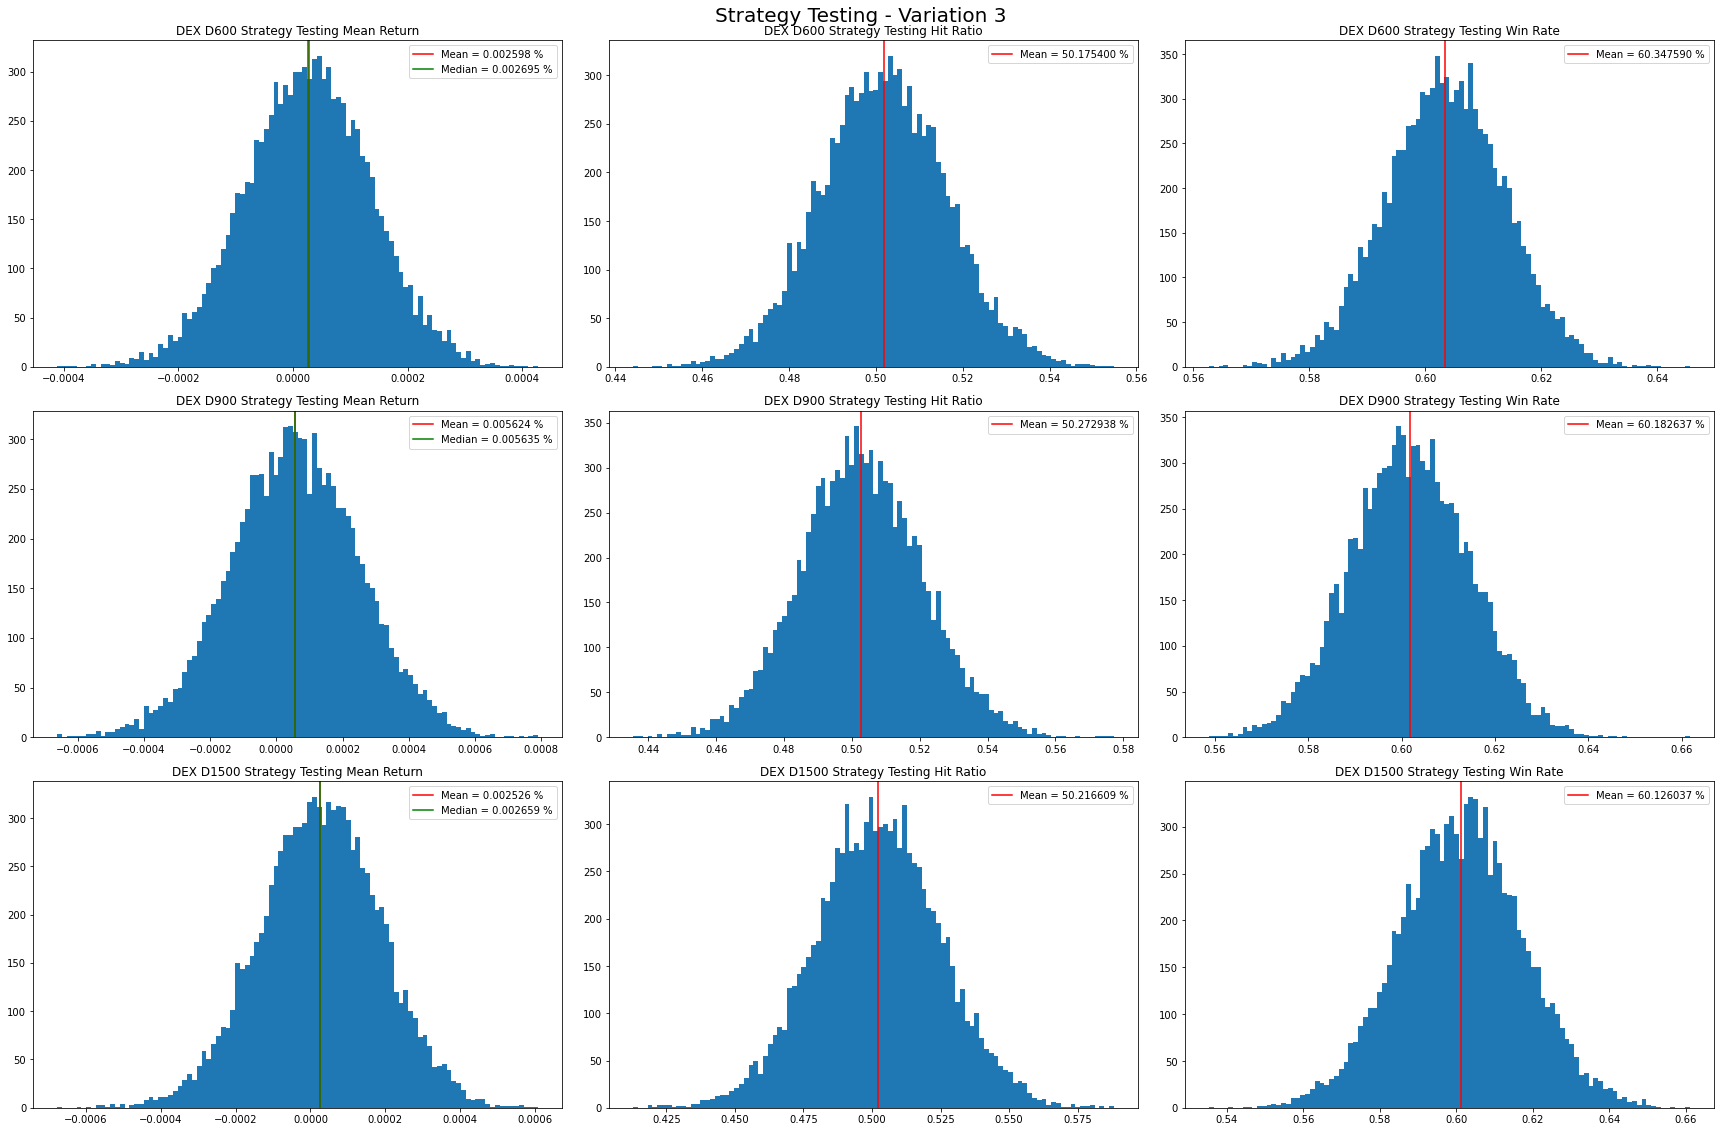

In [17]:
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(24,16))
i=0

strategy_result = pd.read_csv("3M_strategy_double_wait_low_interval.csv")
for index in dex_down_name:

    # Mean Return
    df_plot = strategy_result[strategy_result['index']==index]['Mean Return']
    ax[i,0].hist(df_plot,bins=100)
    ax[i,0].set_title(f"{index} Strategy Testing Mean Return")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,0].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,0].axvline(median_return,color='green',label = f"Median = {median_return*100:.6f} %")
    ax[i,0].legend()

    # Hit Ratio
    df_plot = strategy_result[strategy_result['index']==index]['Hit Ratio']
    ax[i,1].hist(df_plot,bins=100)
    ax[i,1].set_title(f"{index} Strategy Testing Hit Ratio")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,1].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,1].legend()

    # Win Rate 
    df_plot = strategy_result[strategy_result['index']==index]['Win Rate']
    ax[i,2].hist(df_plot,bins=100)
    ax[i,2].set_title(f"{index} Strategy Testing Win Rate")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,2].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,2].legend()
    
    i+=1

plt.suptitle("Strategy Testing - Variation 3",fontsize=20);
plt.tight_layout();


In [18]:
# Simulation Code is here:

# n = 86400*90
# n_sim = 10000
# dex_indices = ["DEX D600","DEX D900","DEX D1500"]

# with alive_bar(len(dex_indices)*n_sim,force_tty=True) as bar:
#     sim_result = []
#     for index in dex_indices:

#         if index == "DEX D600":
#             t_exclude = 10*60
#             interval = 10*60
#             jump_size = -0.2/100

#         elif index == "DEX D900":
#             t_exclude = 15*60
#             interval = 15*60
#             jump_size = -0.3/100

#         elif index == "DEX D1500":     
#             t_exclude = 25*60
#             interval = 25*60
#             jump_size = -0.2/100

#         for i in range(n_sim):
#             S_mv=DEX_sim(index,n=n)
#             r_mv = S_mv[1:]/S_mv[:-1]-1
#             S_mv=S_mv[1:]
    
#             jump = np.arange(len(S_mv))

#             jump = jump[r_mv<jump_size]
#             result = []

#             for j in range(len(jump)-1):
#                 if (jump[j+1]-jump[j]) < t_exclude+1:
#                     next
#                 else:
#                     entry_time = jump[j]+t_exclude
#                     avg_price = np.mean(S_mv[jump[j]+t_exclude:jump[j+1]]) 
#                     while entry_time < jump[j+1]:
#                         entry_price = S_mv[entry_time]
#                         exit_price = S_mv[jump[j+1]]
#                         result.append([entry_time,jump[j+1],entry_price,avg_price,exit_price,entry_price/exit_price-1, entry_price-exit_price,avg_price-exit_price])
#                         entry_time += interval

#             result = np.array(result)
#             win_rate = np.sum(result[:,-2]>0)/len(result)
#             hit_ratio = np.sum(np.where(result[:,-2]>0,result[:,-2],0))/np.sum(np.abs(result[:,-2]))
#             mean_pl = np.mean(result[:,-2])
#             median_pl = np.median(result[:,-2])
#             mean_return = np.mean(result[:,-3])
#             median_return = np.median(result[:,-3])
#             sim_result.append([index,i,hit_ratio,win_rate,mean_pl,median_pl,mean_return,median_return])  
#             bar()
            
# strategy_result = pd.DataFrame(sim_result)
# strategy_result.columns = ['index','sim','Hit Ratio','Win Rate','Mean PL','Median PL','Mean Return','Median Return']
# strategy_result.head(10)




### Section 5

In here we check the correlations between each UP or DOWN DEX indices. The correlation is important for the concentration risk diversification.

Overall, it looks fine.

#### <u>For DEX UP </u>


##### <u>Tickly</u>

In [19]:
# Merge or concatenate your dataframes into a single dataframe
combined_df = pd.concat([dex_u600['return'], dex_u900['return'], dex_u1500['return']], axis=1)
combined_df.columns = ['DEX U600','DEX U900','DEX U1500']
# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Print the correlation matrix
print(correlation_matrix)

             DEX U600    DEX U900   DEX U1500
DEX U600   1.00000000 -0.00005356 -0.00009738
DEX U900  -0.00005356  1.00000000 -0.00099314
DEX U1500 -0.00009738 -0.00099314  1.00000000


##### <u>Hourly</u>

In [20]:
# Merge or concatenate your dataframes into a single dataframe
combined_df = pd.concat([dex_u600['hourly_return'], dex_u900['hourly_return'], dex_u1500['hourly_return']], axis=1)
combined_df.columns = ['DEX U600','DEX U900','DEX U1500']
# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Print the correlation matrix
print(correlation_matrix)

             DEX U600    DEX U900   DEX U1500
DEX U600   1.00000000  0.08863632  0.00939919
DEX U900   0.08863632  1.00000000 -0.05071911
DEX U1500  0.00939919 -0.05071911  1.00000000


##### <u>For DEX DOWN</u>

##### <u>Tickly</u>

In [72]:
# Merge or concatenate your dataframes into a single dataframe
combined_df = pd.concat([dex_d600['return'], dex_d900['return'], dex_d1500['return']], axis=1)
combined_df.columns = ['DEX D600','DEX D900','DEX D1500']
# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Print the correlation matrix
print(correlation_matrix)

             DEX D600    DEX D900   DEX D1500
DEX D600   1.00000000 -0.00109056  0.00022100
DEX D900  -0.00109056  1.00000000 -0.00013249
DEX D1500  0.00022100 -0.00013249  1.00000000


##### <u>Hourly</u>

In [73]:
# Merge or concatenate your dataframes into a single dataframe
combined_df = pd.concat([dex_d600['hourly_return'], dex_d900['hourly_return'], dex_d1500['hourly_return']], axis=1)
combined_df.columns = ['DEX D600','DEX D900','DEX D1500']
# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Print the correlation matrix
print(correlation_matrix)

             DEX D600    DEX D900   DEX D1500
DEX D600   1.00000000  0.02069979  0.01597954
DEX D900   0.02069979  1.00000000  0.04598549
DEX D1500  0.01597954  0.04598549  1.00000000


R&D effort needs to be in line with Deriv’s vision and mission as formulated by our CEO. Therefore all R&D projects are carefully selected by our C-Level senior management represented by JY and Rakshit and resources for the projects are only allocated after review and shortlisting based on their vision and priorities. 

In line with the standards and criterias set out by the CEO, the Model Validation team has validated the product/indices as documented in this report.